<a href="https://colab.research.google.com/github/lofilippini/Planejamento_EE/blob/main/T1b_Grupo06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')
import os
os.chdir("/content/gdrive/My Drive/T1b [PE]/Dados")

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statistics import mean

font = {'size'   : 16}

plt.rc('font', **font)

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from scipy import stats

#Toolbox

In [ ]:
def dados(arq, aplic): 
  global temps
  global rads

  global temps_prev
  global rads_prev

  df = pd.read_csv(arq, sep = ";", decimal=",")

  if aplic == 'm':
    df['Data'] = pd.date_range(start='1/1/2022', periods=len(df), freq='H')
    #df = df.loc[lambda x: x['Data'].dt.month == 5, :]
  elif aplic == 'p':
    df['Data'] = pd.date_range(start='6/1/2022', periods=len(df), freq='H')

  df.index = np.arange(0, len(df))

  dft = df[['Data', 'Temp. Ins. (C)']]
  dfr = df[['Data', 'Radiacao (KJ/m²)']]

  dft = dft.rename(columns={'Temp. Ins. (C)': 'Temperatura [°C]'})
  dft = dft[['Data', 'Temperatura [°C]']]
  dfr = dfr.rename(columns={'Radiacao (KJ/m²)': 'Radiacao [KJ/m²]'})
  dfr = dfr[['Data', 'Radiacao [KJ/m²]']]

  dft['Temperatura [°C]'].fillna(dft['Temperatura [°C]'].median(), inplace=True) 
  dfr['Radiacao [KJ/m²]'].fillna(0, inplace=True) 

  if aplic == 'm':
    temps.append(dft['Temperatura [°C]'])
    rads.append(dfr['Radiacao [KJ/m²]'])
  elif aplic == 'p':
    temps_prev.append(dft['Temperatura [°C]'])
    rads_prev.append(dfr['Radiacao [KJ/m²]'])

  return dft, dfr


def dados_alt(arq, aplic): 
  global temps
  global rads

  global temps_prev
  global rads_prev

  df = pd.read_csv(arq, sep = ",")

  if aplic == 'm':
    df['Data'] = pd.date_range(start='1/1/2022', periods=len(df), freq='H')
    #df = df.loc[lambda x: x['Data'].dt.month >= 4, :]
  elif aplic == 'p':
    df['Data'] = pd.date_range(start='6/1/2022', periods=len(df), freq='H')

  df.index = np.arange(0, len(df))

  dft = df[['Data', 'Temp. Ins. (C)']]
  dfr = df[['Data', 'Radiacao (KJ/m²)']]

  dft = dft.rename(columns={'Temp. Ins. (C)': 'Temperatura [°C]'})
  dft = dft[['Data', 'Temperatura [°C]']]
  dfr = dfr.rename(columns={'Radiacao (KJ/m²)': 'Radiacao [KJ/m²]'})
  dfr = dfr[['Data', 'Radiacao [KJ/m²]']]

  dft['Temperatura [°C]'].fillna(dft['Temperatura [°C]'].median(), inplace=True) 
  dfr['Radiacao [KJ/m²]'].fillna(0, inplace=True) 

  if aplic == 'm':
    temps.append(dft['Temperatura [°C]'])
    rads.append(dfr['Radiacao [KJ/m²]'])
  elif aplic == 'p':
    temps_prev.append(dft['Temperatura [°C]'])
    rads_prev.append(dfr['Radiacao [KJ/m²]'])

  return dft, dfr

In [ ]:
def temperaturas(arq): 
  global temps

  df = pd.read_csv(arq, sep = ";", decimal=",")

  df = df[['Temp. Ins. (C)']]
  df['Data'] = pd.date_range(start='1/1/2022', periods=len(df), freq='H')

  df = df.rename(columns={'Temp. Ins. (C)': 'Temperatura [°C]'})
  df = df[['Data', 'Temperatura [°C]']]

  if arq == "Modelo/cuiaba.csv":
    df['Temperatura [°C]'].fillna(0, inplace=True) 
  else:
    df['Temperatura [°C]'].fillna(df['Temperatura [°C]'].median(), inplace=True) 

  df = df.loc[lambda x: x['Data'].dt.month == 5, :]
  df.index = np.arange(0, len(df))
  df.reset_index()

  temps.append(df['Temperatura [°C]'])

  return df


def radiacao(arq): 
  global rads

  df = pd.read_csv(arq, sep = ";", decimal=",")

  df = df[['Radiacao (KJ/m²)']]
  df['Data'] = pd.date_range(start='1/1/2022', periods=len(df), freq='H')

  df = df.rename(columns={'Radiacao (KJ/m²)': 'Radiacao [KJ/m²]'})
  df = df[['Data', 'Radiacao [KJ/m²]']]

  df['Radiacao [KJ/m²]'].fillna(0, inplace=True) 

  df = df.loc[lambda x: x['Data'].dt.month == 5, :]
  df.index = np.arange(0, len(df))
  df.reset_index()

  rads.append(df['Radiacao [KJ/m²]'])

  return df

In [ ]:
def regr_multilinear(x, y):
  x_mat = x.to_numpy()
  y_mat = y.to_numpy()

  x_t = x_mat.transpose()
  prod = np.matmul(x_t, x_mat)

  inv = np.linalg.pinv(prod)

  coef = np.matmul(np.matmul(inv, x_t), y_mat)
  coef = np.concatenate(coef)
  coef = coef.tolist()

  prev = []

  for i in range(len(x_t)):
    for c in coef:
      if coef.index(c) == 0:
        res = c
      else:
        res = res + c*x[coef.index(c)-1][i]
    
    prev.append(res)

  prev = pd.DataFrame(prev)
  return prev


def regr_quad(x, y):
  fit = np.polyfit(x, y, 2)

  fit = np.concatenate(fit)
  fit = fit.tolist()

  prev = []

  for i in range(len(x)):
    res = 0
    for c in fit:
      res = c*x[i]**(fit.index(c))
    
    prev.append(res)

  prev = pd.DataFrame(prev)
  return prev

#Importação e manipulação preliminar dos dados

## Dados de consumo

In [ ]:
# Carga horária
df_ch = pd.read_excel("carga_h.xlsx", header = None)
df_ch = df_ch.drop([0, 1])
df_ch = df_ch.drop([0], axis = 1)

df_ch = df_ch.transpose()
df_ch = df_ch[:-1]

df_ch['Data'] = pd.date_range(start='1/1/2022', periods=len(df_ch), freq='H')
df_ch = df_ch.rename(columns={1: 'Data', 2: 'Consumo [MWh]'})
df_ch = df_ch[['Data', 'Consumo [MWh]']]

df_ch['Consumo [MWh]'] = df_ch['Consumo [MWh]'].astype(float)

df_ch.index = np.arange(0, len(df_ch))
df_ch.reset_index()

#df_ch = df_ch.loc[lambda x: x['Data'].dt.month ==5, :]
df_ch.index = np.arange(0, len(df_ch))
df_ch.reset_index()

NameError: ignored

## Temperaturas e radiação

In [ ]:
temps = []
rads = []
temps.clear()
rads.clear()

dados("Modelo/sao_paulo.csv", 'm')
dados("Modelo/brasilia.csv", 'm')
dados("Modelo/rio_janeiro.csv", 'm')
#dados("Modelo/cuiaba.csv", 'm')
dados("Modelo/belo_horizonte.csv", 'm')
dados("Modelo/goiania.csv", 'm')
#dados("Modelo/campo_grande.csv", 'm')
#dados("Modelo/vitoria.csv", 'm')
#dados("Modelo/rio_branco.csv", 'm')
#dados("Modelo/porto_velho.csv", 'm')

xt = pd.concat(temps, axis=1, ignore_index=True)
xr = pd.concat(rads, axis=1, ignore_index=True)

x = pd.concat([xt, xr], axis=1, ignore_index=True)
x.insert(0, 'Cte', np.ones(len(df_ch['Data']), dtype=int))

y = pd.DataFrame(df_ch['Consumo [MWh]'].astype(float))

# Obtenção dos modelos horários de regressão

## Sem separação

R2 = 0.5751


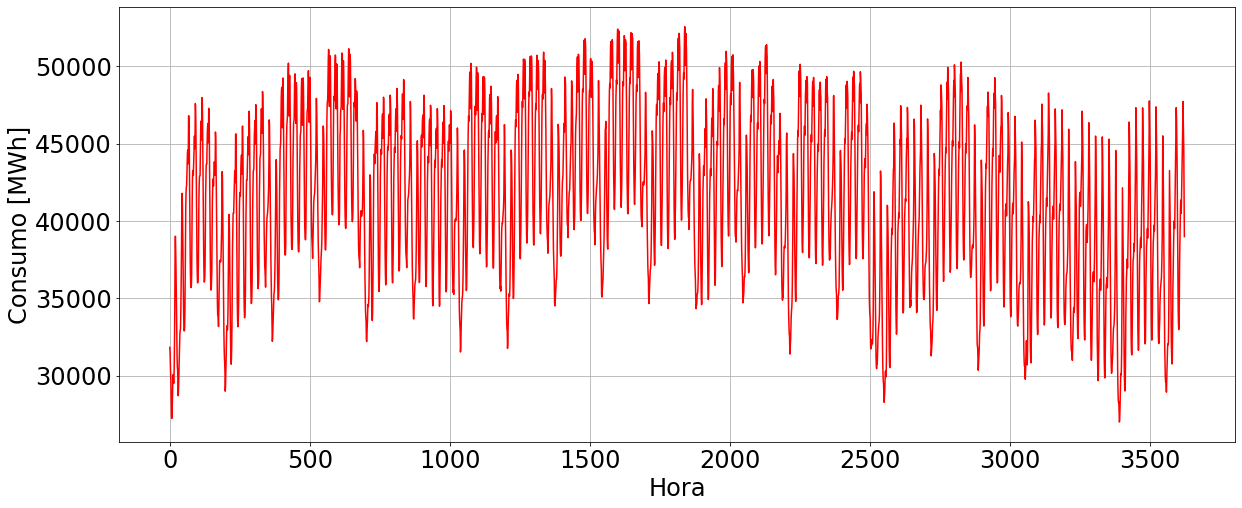

In [ ]:
xh = xt.copy()
xht = xt.copy()

xh['Data'] = pd.date_range(start='1/1/2022', periods=len(df_ch), freq='H')
xht['Data'] = pd.date_range(start='1/1/2022', periods=len(df_ch), freq='H')

xhoras = {}
xhorast = {}
yhoras = {}
models = {}
predictions = {}

for hora in range(24):
  xhoras[hora] = xh.loc[lambda x: x['Data'].dt.hour == hora, :]
  xhorast[hora] = xht.loc[lambda x: x['Data'].dt.hour == hora, :]
  yhoras[hora] = df_ch.loc[lambda y: y['Data'].dt.hour == hora, :]

  xhoras[hora] = xhoras[hora].drop(['Data'], axis = 1)
  xhorast[hora] = xhorast[hora].drop(['Data'], axis = 1)
  yhoras[hora] = yhoras[hora].drop(['Data'], axis = 1) 

  if hora < 10: 
    models[hora] = sm.OLS(yhoras[hora], xhorast[hora]).fit()
    predictions[hora] = models[hora].predict(xhorast[hora])
  elif hora >= 10 and hora <= 21:
    models[hora] = sm.OLS(yhoras[hora], xhoras[hora]).fit()
    predictions[hora] = models[hora].predict(xhoras[hora])
  elif hora > 21:
    models[hora] = sm.OLS(yhoras[hora], xhorast[hora]).fit()
    predictions[hora] = models[hora].predict(xhorast[hora])

final = pd.DataFrame(predictions)

results = final.to_numpy()
aux = []


for row in range(len(df_ch)):
  for col in range(24):
    if np.isnan(results[row][col]) == False:
      aux.append(results[row][col])

errosj = []
rmsj = []
sqres = []
sqtot = []
vet_err = []
ybarra = (sum(aux)/len(df_ch))

for i in range(len(df_ch['Data'])):
  err = abs((aux[i] - df_ch['Consumo [MWh]'][i]))/df_ch['Consumo [MWh]'][i]
  sqres.append((df_ch['Consumo [MWh]'][i] - aux[i])**2)
  sqtot.append((df_ch['Consumo [MWh]'][i] - ybarra)**2)
  rmsj.append((err/100)**2)
  errosj.append(err)
  vet_err.append(err*100)
  

SQtot = sum(sqtot)
SQres = sum(sqres)
epam = sum(errosj)*100/len(df_ch['Data'])


R2 = 1 - SQres/SQtot
Ra2 = 1 - ((len(sqres) - 1)/(len(sqres) - (8 + 1)))*(1-R2)
F = ((len(sqres) - (8 + 1))/8)*(R2/(1 - R2))

fig,ax = plt.subplots(figsize=(20, 8))


ax.plot(df_ch.index, df_ch["Consumo [MWh]"], color="r", label = "Consumo real")
ax.set_xlabel("Hora", fontsize = 24)
#ax.plot(df_ch.index, aux, color="b", label = "Consumo previsto")
ax.set_ylabel("Consumo [MWh]", fontsize=24)
#ax.grid()

#ax.legend()
#ax2=ax.twinx()
plt.yticks(fontsize = 24)
plt.xticks(fontsize = 24)
#ax2.plot(df_ch.index, vet_err, color="r", label = "Erro relativo", linestyle = ':', linewidth = 2)
#ax2.set_ylabel("Erro relativo [%]", fontsize=18)
ax.grid()

print(f'R2 = {round(R2, 4)}')

## Separação por dias da semana e finais de semana

EPAM = 3.707 %
R2 = 0.8759


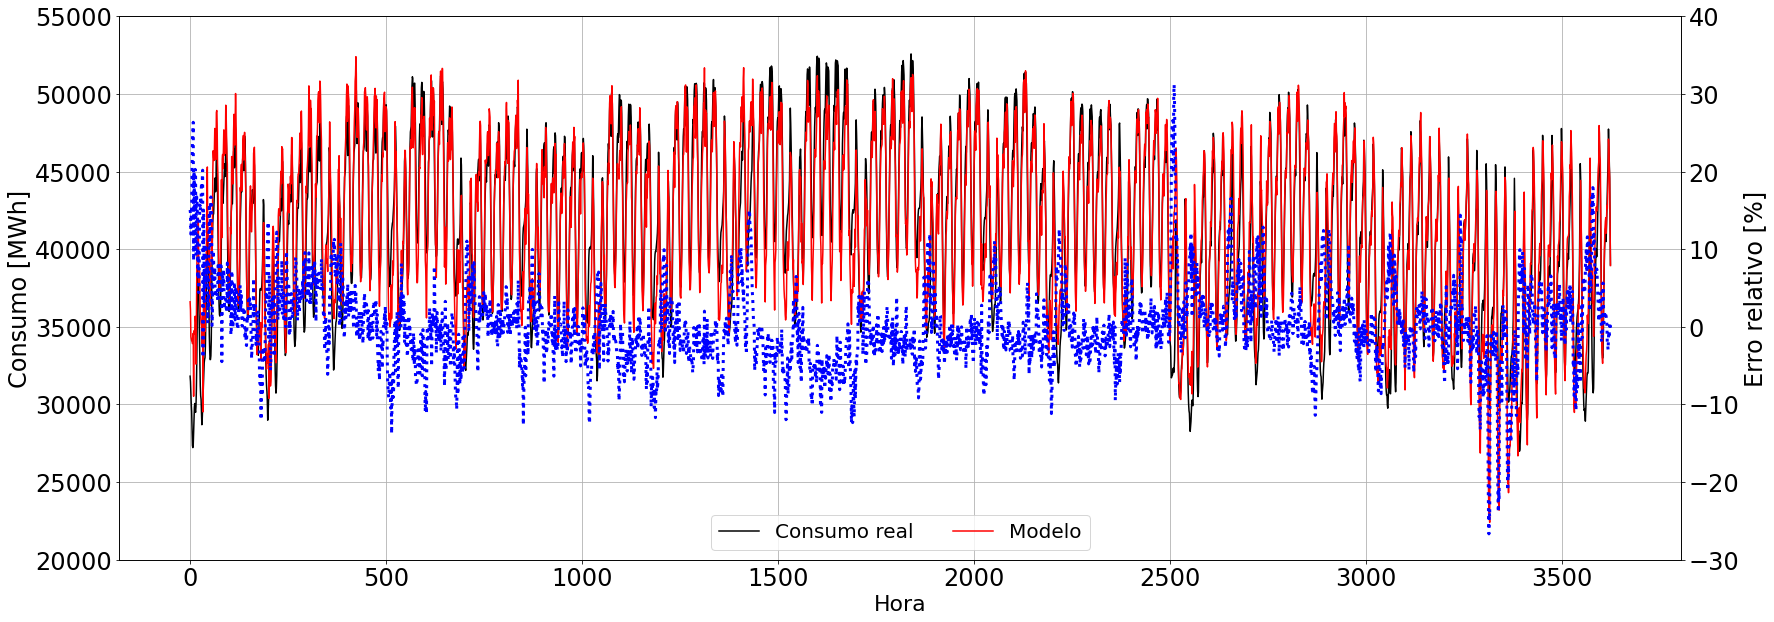

In [ ]:
xh = x.copy()
xht = xt.copy()
xh['Data'] = pd.date_range(start='1/1/2022', periods=len(df_ch), freq='H')
xht['Data'] = pd.date_range(start='1/1/2022', periods=len(df_ch), freq='H')

xweek = xh.loc[lambda x: x['Data'].dt.weekday < 5, :]
xweekt = xht.loc[lambda x: x['Data'].dt.weekday < 5, :]
yweek = df_ch.loc[lambda y: y['Data'].dt.weekday < 5, :]

xwknd = xh.loc[lambda x: x['Data'].dt.weekday >= 5, :]
xwkndt = xht.loc[lambda x: x['Data'].dt.weekday >= 5, :]
ywknd = df_ch.loc[lambda y: y['Data'].dt.weekday >= 5, :]

xhweek= {}
xhweekt = {}
yhweek = {}
xhwknd = {}
xhwkndt = {}
yhwknd = {}

model_week = {}
predict_week = {}
model_wknd = {}
predict_wknd = {}
sumarios_week = {}
sumarios_wknd = {}


for hora in range(24):
  xhweek[hora] = xweek.loc[lambda x: x['Data'].dt.hour == hora, :]
  xhweekt[hora] = xweekt.loc[lambda x: x['Data'].dt.hour == hora, :]
  yhweek[hora] = yweek.loc[lambda y: y['Data'].dt.hour == hora, :]
  xhwknd[hora] = xwknd.loc[lambda x: x['Data'].dt.hour == hora, :]
  xhwkndt[hora] = xwkndt.loc[lambda x: x['Data'].dt.hour == hora, :]
  yhwknd[hora] = ywknd.loc[lambda y: y['Data'].dt.hour == hora, :]

  xhweek[hora] = xhweek[hora].drop(['Data'], axis = 1)
  xhweekt[hora] = xhweekt[hora].drop(['Data'], axis = 1)
  yhweek[hora] = yhweek[hora].drop(['Data'], axis = 1)
  xhwknd[hora] = xhwknd[hora].drop(['Data'], axis = 1)
  xhwkndt[hora] = xhwkndt[hora].drop(['Data'], axis = 1)
  yhwknd[hora] = yhwknd[hora].drop(['Data'], axis = 1)

  if hora < 4: 
    model_week[hora] = sm.OLS(yhweek[hora], xhweekt[hora]).fit()
    predict_week[hora] = model_week[hora].predict(xhweekt[hora])

    model_wknd[hora] = sm.OLS(yhwknd[hora], xhwkndt[hora]).fit()
    predict_wknd[hora] = model_wknd[hora].predict(xhwkndt[hora])
  elif hora >= 4 and hora <= 22:
    model_week[hora] = sm.OLS(yhweek[hora], xhweek[hora]).fit()
    predict_week[hora] = model_week[hora].predict(xhweek[hora])

    model_wknd[hora] = sm.OLS(yhwknd[hora], xhwknd[hora]).fit()
    predict_wknd[hora] = model_wknd[hora].predict(xhwknd[hora])
  elif hora > 22:
    model_week[hora] = sm.OLS(yhweek[hora], xhweekt[hora]).fit()
    predict_week[hora] = model_week[hora].predict(xhweekt[hora])

    model_wknd[hora] = sm.OLS(yhwknd[hora], xhwkndt[hora]).fit()
    predict_wknd[hora] = model_wknd[hora].predict(xhwkndt[hora])


# Plotting
final_week = pd.DataFrame(predict_week)
final_wknd = pd.DataFrame(predict_wknd)

auxiliar = pd.concat([final_wknd, final_week], sort=False).sort_index()

modelo = auxiliar.to_numpy()
alt = []

for row in range(len(df_ch)):
  for col in range(24):
    if np.isnan(modelo[row][col]) == False:
      alt.append(modelo[row][col])

erros = []
rms = []
sqresm = []
sqtotm = []
ybarram = (sum(alt)/len(alt))
veterrosm = []

for i in range(len(df_ch['Data'])):
  err = ((alt[i] - df_ch['Consumo [MWh]'][i]))/df_ch['Consumo [MWh]'][i]
  sqresm.append((df_ch['Consumo [MWh]'][i] - alt[i])**2)
  sqtotm.append((df_ch['Consumo [MWh]'][i] - ybarram)**2)
  rms.append((err/100)**2)
  erros.append(abs(err))
  veterrosm.append(err*100)

SQtotm = sum(sqtotm)
SQresm = sum(sqresm)
err_rms = (sum(rms)/len(rms))**(1/2)
epammod = sum(erros)*100/len(df_ch['Data'])

R2m = 1 - SQresm/SQtotm
Ra2m = 1 - ((len(sqresm) - 1)/(len(sqresm) - (8 + 1)))*(1-R2m)
Fm = ((len(sqresm) - (8 + 1))/8)*(R2m/(1 - R2m))


fig,ax = plt.subplots(figsize=(28, 10))

font = {'size'   : 20}
plt.rc('font', **font)

ax.plot(df_ch.index, df_ch["Consumo [MWh]"], color="black", label = "Consumo real")
ax.set_xlabel("Hora", fontsize = 22)
ax.plot(df_ch.index, alt, color="r", label = "Modelo")
#ax.plot(df_ch.index, aux, color="g", label = "Consumo previsto integral")
ax.set_ylabel("Consumo [MWh]", fontsize=24)
ax.grid()

plt.yticks(fontsize = 24)
plt.xticks(fontsize = 24)
ax.legend(loc = 'lower center', ncol = 2)
ax2=ax.twinx()
plt.yticks(fontsize = 24)
#plt.xticks(np.arange(0, len(df_ch['Data']), 240), fontsize = 22)

ax2.plot(df_ch.index, veterrosm, color="b", label = "Erro relativo", linestyle = ':', linewidth = 3)
ax2.set_ylabel("Erro relativo [%]", fontsize=24)

ax.set_yticks(range(20000,60000,5000))
ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))

print(f'EPAM = {round((epammod), 3)} %')
print(f'R2 = {round(R2m, 4)}')
#print(f'R2_adj = {round(Ra2m, 4)}')
#print(f'F = {round(Fm, 4)}')

## Modelo dia a dia

EPAM = 2.513%
R2 = 0.9385


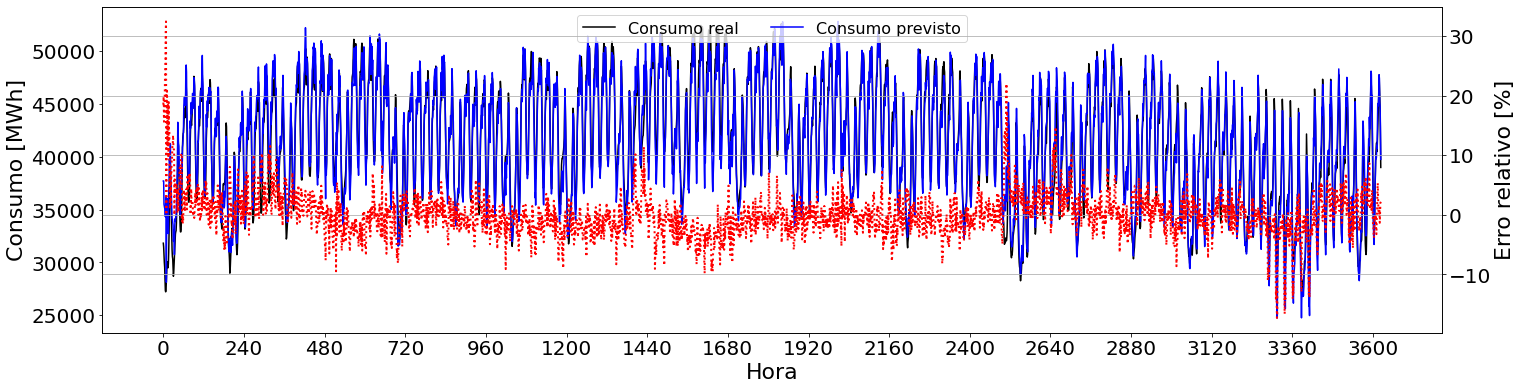

In [ ]:
xh = x.copy()
xht = xt.copy()
xh['Data'] = pd.date_range(start='1/1/2022', periods=len(df_ch), freq='H')
xht['Data'] = pd.date_range(start='1/1/2022', periods=len(df_ch), freq='H')

xweek = {}
xweekn = {}
yweek = {}

for dia in range(7):
  xweek[dia] = xh.loc[lambda x: x['Data'].dt.weekday == dia, :]
  xweekn[dia] = xht.loc[lambda x: x['Data'].dt.weekday == dia, :]
  yweek[dia] = df_ch.loc[lambda y: y['Data'].dt.weekday == dia, :]

ord_dias = []
ord_dias.clear()

for dia in xh['Data']:
  ord_dias.append(dia.weekday())

ordem_geral = list(dict.fromkeys(ord_dias))


xhday = {}
xhdayn = {}
yhday = {}

model_day = {}
predict_day = {}
sumarios_day = {}

lista_dias = []

model_weekd = {}
predict_weekd = []
sumarios_weekd = {}


for dia in ordem_geral: 
  lista_horas = [] 
  for hora in range(24):
    xhday[hora] = xweek[dia].loc[lambda x: x['Data'].dt.hour == hora, :]
    xhdayn[hora] = xweekn[dia].loc[lambda x: x['Data'].dt.hour == hora, :]
    yhday[hora] = yweek[dia].loc[lambda y: y['Data'].dt.hour == hora, :]

    xhday[hora] = xhday[hora].drop(['Data'], axis = 1)
    xhdayn[hora] = xhdayn[hora].drop(['Data'], axis = 1)
    yhday[hora] = yhday[hora].drop(['Data'], axis = 1)

    if hora < 4: 
      model_day[hora] = sm.OLS(yhday[hora], xhdayn[hora]).fit()
      predict_day[hora] = model_day[hora].predict(xhdayn[hora])

      lista_horas.append(model_day[hora])
    elif hora >= 4 and hora <= 22:
      model_day[hora] = sm.OLS(yhday[hora], xhday[hora]).fit()
      predict_day[hora] = model_day[hora].predict(xhday[hora])

      lista_horas.append(model_day[hora])
    elif hora > 22:
      model_day[hora] = sm.OLS(yhday[hora], xhdayn[hora]).fit()
      predict_day[hora] = model_day[hora].predict(xhdayn[hora])

      lista_horas.append(model_day[hora])

  lista_dias.append(lista_horas)
  #print(model_weekd[dia])
  predict_weekd.append(pd.DataFrame(predict_day))

  xhday.clear()
  xhdayn.clear()
  yhday.clear()
  model_day.clear()
  predict_day.clear()

# Plotting

model_weekd = dict(zip(ordem_geral, lista_dias))
#sorted_week = dict(sorted(model_weekd.items()))

auxiliar1 = pd.concat(predict_weekd, sort=False).sort_index()

modelo_diario = auxiliar1.to_numpy()
altdia = []

for row in range(len(df_ch)):
  for col in range(24):
    if np.isnan(modelo_diario[row][col]) == False:
      altdia.append(modelo_diario[row][col])

erros = []
rms = []
sqresm = []
sqtotm = []
ybarram = (sum(altdia)/len(altdia))
veterros = []

for i in range(len(df_ch['Data'])):
  err = ((altdia[i] - df_ch['Consumo [MWh]'][i]))/df_ch['Consumo [MWh]'][i]
  sqresm.append((df_ch['Consumo [MWh]'][i] - altdia[i])**2)
  sqtotm.append((df_ch['Consumo [MWh]'][i] - ybarram)**2)
  rms.append((err/100)**2)
  erros.append(abs(err))
  veterros.append(err*100)

SQtotm = sum(sqtotm)
SQresm = sum(sqresm)
err_rms = (sum(rms)/len(rms))**(1/2)
epamm = sum(erros)*100/len(df_ch['Data'])

R2m = 1 - SQresm/SQtotm
#Ra2m = 1 - ((len(sqresm) - 1)/(len(sqresm) - (8 + 1)))*(1-R2m)
#Fm = ((len(sqresm) - (8 + 1))/8)*(R2m/(1 - R2m))


fig,ax = plt.subplots(figsize=(24, 6))

ax.plot(df_ch.index, df_ch["Consumo [MWh]"], color="black", label = "Consumo real")
ax.set_xlabel("Hora", fontsize = 22)
ax.plot(df_ch.index, altdia, color="b", label = "Consumo previsto")
#ax.plot(df_ch.index, aux, color="g", label = "Consumo previsto integral")
ax.set_ylabel("Consumo [MWh]", fontsize=22)
#ax.grid()

ax.legend(loc = 'upper center', ncol = 2, fontsize = 16)
ax2=ax.twinx()
ax.set_xticks(np.arange(0,len(df_ch['Data']), 240))
ax2.plot(df_ch.index, veterros, color="r", label = "Erro relativo", linestyle = ':', linewidth = 2)
ax2.set_ylabel("Erro relativo [%]", fontsize=22)
ax2.grid()

print(f'EPAM = {round((epamm), 3)}%')
print(f'R2 = {round(R2m, 4)}')
#print(f'R2_adj = {round(Ra2m, 4)}')
#print(f'F = {round(Fm, 4)}')

# Previsão de consumo para junho

## Importação 

In [ ]:
df_jun = pd.read_excel("Previsao/carga_junho.xlsx", header = None)
df_jun = df_jun.drop([0, 1])
df_jun = df_jun.drop([0], axis = 1)

df_jun = df_jun.transpose()
df_jun = df_jun[:-1]

df_jun['Data'] = pd.date_range(start='6/1/2022', periods=len(df_jun), freq='H')
df_jun = df_jun.rename(columns={1: 'Data', 2: 'Consumo [MWh]'})
df_jun = df_jun[['Data', 'Consumo [MWh]']]

df_jun['Consumo [MWh]'] = df_jun['Consumo [MWh]'].astype(float)

df_jun.index = np.arange(0, len(df_jun))
df_jun.reset_index()

temps_prev = []
rads_prev = []
temps_prev.clear()
rads_prev.clear()

dados("Previsao/sao_paulo.csv", 'p')
dados("Previsao/brasilia.csv", 'p')
dados("Previsao/rio_janeiro.csv", 'p')
#dados("Previsao/cuiaba.csv", 'p')
dados("Previsao/belo_horizonte.csv", 'p')
dados("Previsao/goiania.csv", 'p')
#dados("Previsao/campo_grande.csv", 'p')
#dados("Previsao/vitoria.csv", 'p')
#dados("Previsao/rio_branco.csv", 'p')
#dados("Previsao/porto_velho.csv", 'p')

xtj = pd.concat(temps_prev, axis=1, ignore_index=True)
xrj = pd.concat(rads_prev, axis=1, ignore_index=True)

xp = pd.concat([xtj, xrj], axis=1, ignore_index=True)
xp.insert(0, 'Cte', np.ones(len(df_jun['Data']), dtype=int))

df_sem = df_jun.loc[lambda x: x['Data'].dt.day >= 6, :]
df_sem = df_sem.loc[lambda x: x['Data'].dt.day <= 12, :]
df_sem.index = np.arange(0, len(df_sem))
df_sem.reset_index()

,index,Data,Consumo [MWh]
0,0,2022-06-06 00:00:00,32060.795
1,1,2022-06-06 01:00:00,30609.095
2,2,2022-06-06 02:00:00,29835.861
3,3,2022-06-06 03:00:00,29716.517
4,4,2022-06-06 04:00:00,30187.591
...,...,...,...
163,163,2022-06-12 19:00:00,39873.684
164,164,2022-06-12 20:00:00,38580.333
165,165,2022-06-12 21:00:00,37195.802
166,166,2022-06-12 22:00:00,35183.732


## Previsão modelo semanal com separação

EPAM = 3.207%
R2 = 0.908


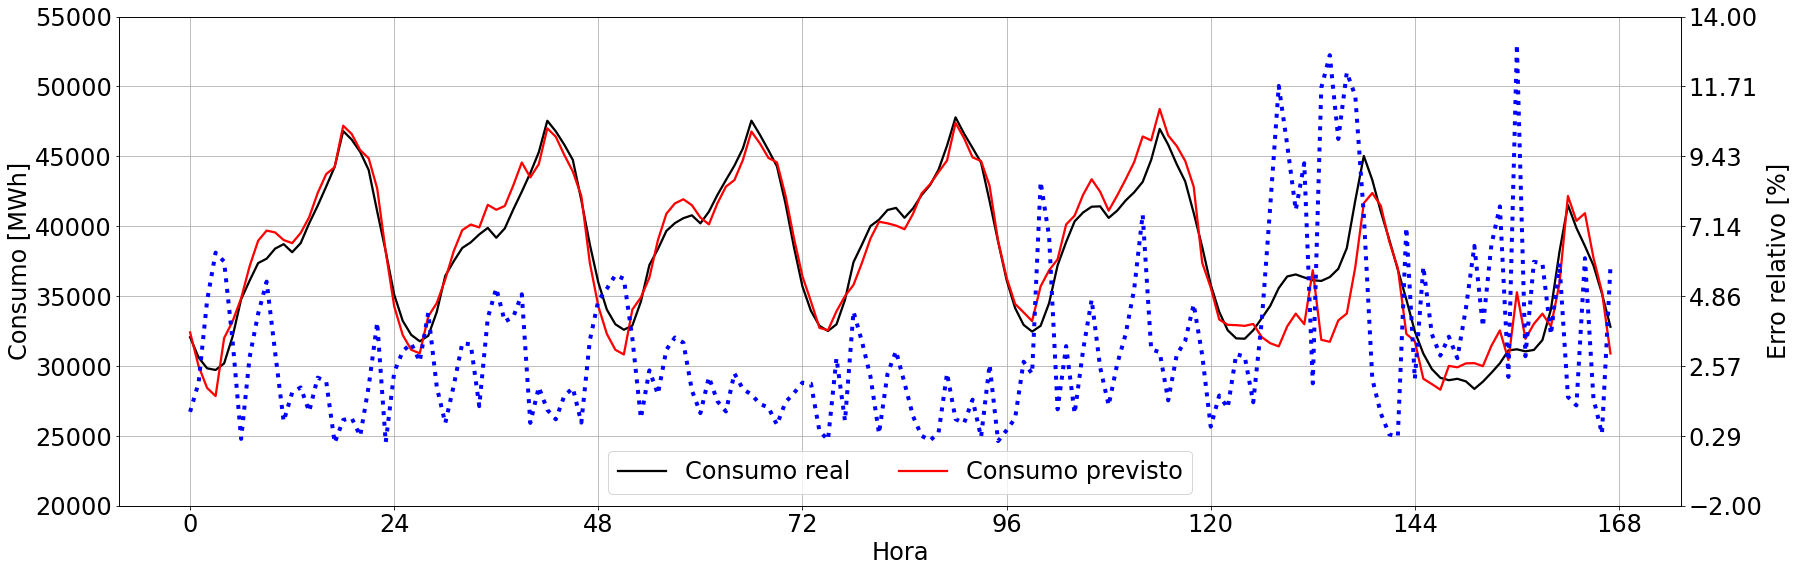

In [ ]:
xh_jun = xp.copy()
xht_jun = xtj.copy()
xh_jun['Data'] = pd.date_range(start='6/1/2022', periods=len(df_jun), freq='H')
xht_jun['Data'] = pd.date_range(start='6/1/2022', periods=len(df_jun), freq='H')

xh_jun = xh_jun.loc[lambda x: x['Data'].dt.day >= 6, :]
xh_jun = xh_jun.loc[lambda x: x['Data'].dt.day <= 12, :]
xht_jun = xht_jun.loc[lambda x: x['Data'].dt.day >= 6, :]
xht_jun = xht_jun.loc[lambda x: x['Data'].dt.day <= 12, :]

semana = xh_jun['Data']

xweek_jun = xh_jun.loc[lambda x: x['Data'].dt.weekday < 5, :]
xwknd_jun = xh_jun.loc[lambda x: x['Data'].dt.weekday >= 5, :]
xweekt_jun = xht_jun.loc[lambda x: x['Data'].dt.weekday < 5, :]
xwkndt_jun = xht_jun.loc[lambda x: x['Data'].dt.weekday >= 5, :]

xjhweek= {}
xjhwknd= {}
xjthweek= {}
xjthwknd= {}

junho_week = {}
junho_wknd = {}


for hora in range(24):
  xjhweek[hora] = xweek_jun.loc[lambda x: x['Data'].dt.hour == hora, :]
  xjhwknd[hora] = xwknd_jun.loc[lambda x: x['Data'].dt.hour == hora, :]
  xjthweek[hora] = xweekt_jun.loc[lambda x: x['Data'].dt.hour == hora, :]
  xjthwknd[hora] = xwkndt_jun.loc[lambda x: x['Data'].dt.hour == hora, :]

  xjhweek[hora] = xjhweek[hora].drop(['Data'], axis = 1)
  xjhwknd[hora] = xjhwknd[hora].drop(['Data'], axis = 1)
  xjthweek[hora] = xjthweek[hora].drop(['Data'], axis = 1)
  xjthwknd[hora] = xjthwknd[hora].drop(['Data'], axis = 1)
  
  if hora < 4: 
    junho_week[hora] = model_week[hora].predict(xjthweek[hora])
    junho_wknd[hora] = model_wknd[hora].predict(xjthwknd[hora])
  elif hora >= 4 and hora <= 22:
    junho_week[hora] = model_week[hora].predict(xjhweek[hora])
    junho_wknd[hora] = model_wknd[hora].predict(xjhwknd[hora])
  elif hora > 22:
    junho_week[hora] = model_week[hora].predict(xjthweek[hora])
    junho_wknd[hora] = model_wknd[hora].predict(xjthwknd[hora])


final_jweek = pd.DataFrame(junho_week)
final_jwknd = pd.DataFrame(junho_wknd)

aux_jun = pd.concat([final_jweek, final_jwknd], sort=False).sort_index()

previsao_junho = aux_jun.to_numpy()
pjunho = []

for row in range(len(semana)):
  for col in range(24):
    if np.isnan(previsao_junho[row][col]) == False:
      pjunho.append(previsao_junho[row][col])

errosj = []
rmsj = []
sqres = []
sqtot = []
vet_err = []
ybarra = (sum(pjunho)/len(pjunho))

for i in range(len(df_sem['Data'])):
  err = abs((pjunho[i] - df_sem['Consumo [MWh]'][i]))/df_sem['Consumo [MWh]'][i]
  sqres.append((df_sem['Consumo [MWh]'][i] - pjunho[i])**2)
  sqtot.append((df_sem['Consumo [MWh]'][i] - ybarra)**2)
  rmsj.append((err/100)**2)
  errosj.append(abs(err))
  vet_err.append(err*100)
  

SQtot = sum(sqtot)
SQres = sum(sqres)
epam = sum(errosj)*100/len(df_sem['Data'])


R2 = 1 - SQres/SQtot
Ra2 = 1 - ((len(sqres) - 1)/(len(sqres) - (8 + 1)))*(1-R2)
F = ((len(sqres) - (8 + 1))/8)*(R2/(1 - R2))

fig,ax = plt.subplots(figsize=(28, 9))

ax.plot(df_sem.index, df_sem["Consumo [MWh]"], color="black", 
        label = "Consumo real", linewidth = 2.25)
ax.set_xlabel("Hora", fontsize = 24)
ax.plot(df_sem.index, pjunho, color="r", label = "Consumo previsto", 
        linewidth = 2.25)
ax.set_ylabel("Consumo [MWh]", fontsize=24)
#ax.grid()
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)

ax.legend(loc = 'lower center', fontsize = 24, ncol = 2)
ax2=ax.twinx()

ax2.plot(df_sem.index, vet_err, color="b", label = "Erro relativo", 
         linestyle = ':', linewidth = 4)
ax2.set_ylabel("Erro relativo [%]", fontsize=24)
ax.grid()
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)

ax.set_yticks(range(20000,60000,5000))
ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))
plt.xticks(range(0,len(df_sem)+1,24))
#
#ax2.set_yticks(range(0,15,1))
#ax.set_title("Carga em junho")

print(f'EPAM = {round((epam), 3)}%')
print(f'R2 = {round(R2, 4)}')
#print(f'R2_adj = {round(Ra2, 4)}')
#print(f'F = {round(F, 4)}')

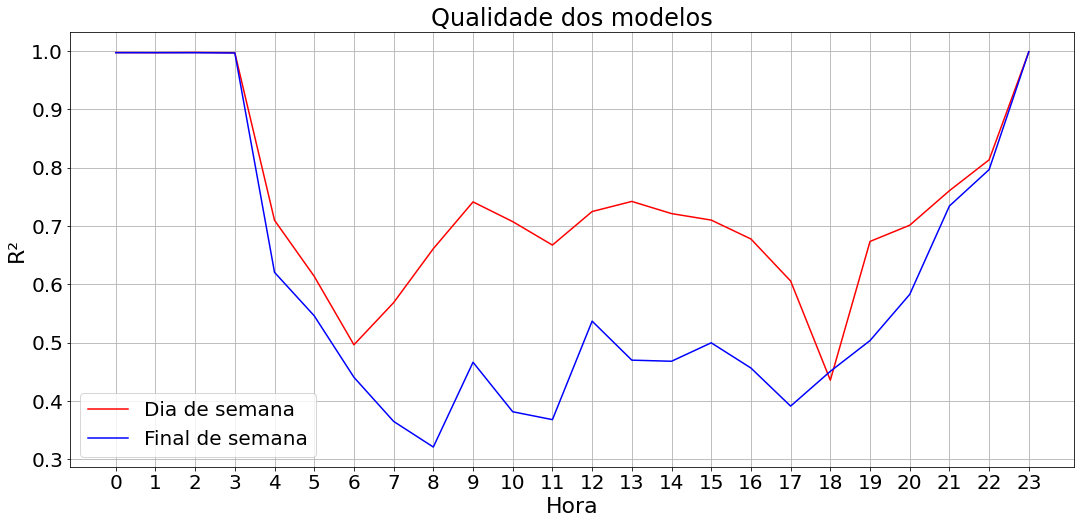

In [ ]:
rquad = []
rquadw = []
rquad.clear()
rquadw.clear()

for modelo in model_week.values():
  rquad.append(modelo.rsquared)

for modelo in model_wknd.values():
  rquadw.append(modelo.rsquared)

fig,ax = plt.subplots(figsize=(18,8))

ax.plot(np.arange(24), rquad, color="r", linewidth = 1.5, label = "Dia de semana")
ax.plot(np.arange(24), rquadw, color="b", linewidth = 1.5, label = "Final de semana")
ax.set_title("Qualidade dos modelos")
ax.set_ylabel("R²", fontsize = 22)
ax.set_xlabel("Hora", fontsize = 22)
ax.legend()
plt.xticks(np.arange(0,24,1))
#plt.yticks(np.arange(0.9,1.001,0.01))
ax.grid()

In [ ]:
for modelo in model_week.values():
  print(modelo.summary())

                                 OLS Regression Results                                
Dep. Variable:          Consumo [MWh]   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              6573.
Date:                Thu, 18 Aug 2022   Prob (F-statistic):                   2.94e-126
Time:                        23:36:24   Log-Likelihood:                         -975.73
No. Observations:                 107   AIC:                                      1961.
Df Residuals:                     102   BIC:                                      1975.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


## Modelo diario

EPAM = 4.218%
R2 = 0.8421


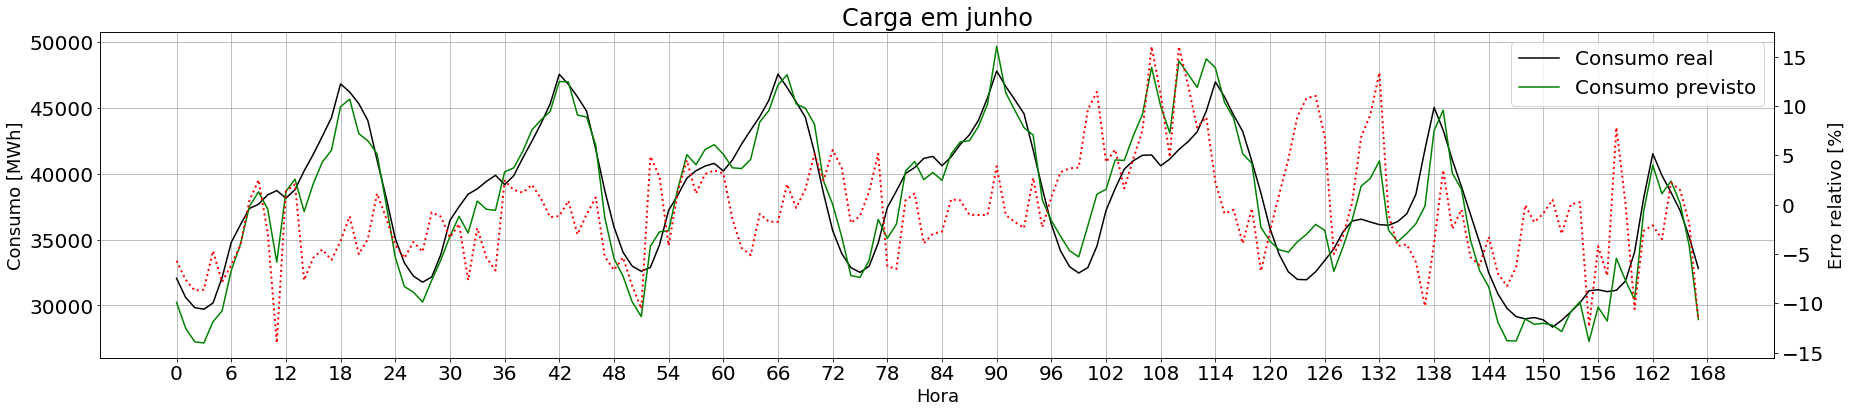

In [ ]:
xh_jund = xp.copy()
xht_jund = xtj.copy()
xh_jund['Data'] = pd.date_range(start='6/1/2022', periods=len(df_jun), freq='H')
xht_jund['Data'] = pd.date_range(start='6/1/2022', periods=len(df_jun), freq='H')

xh_jund = xh_jund.loc[lambda x: x['Data'].dt.day >= 6, :] 
xh_jund = xh_jund.loc[lambda x: x['Data'].dt.day <= 12, :]
xht_jund = xht_jund.loc[lambda x: x['Data'].dt.day >= 6, :]
xht_jund = xht_jund.loc[lambda x: x['Data'].dt.day <= 12, :]

xweekj = {}
xweeknj = {}

for dia in range(7):
  xweekj[dia] = xh_jund.loc[lambda x: x['Data'].dt.weekday == dia, :]
  xweeknj[dia] = xht_jund.loc[lambda x: x['Data'].dt.weekday == dia, :]


dia_semana = []
dia_semana.clear()

for dia in xh_jund['Data']:
  dia_semana.append(dia.weekday())

ordem = list(dict.fromkeys(dia_semana))


xhdayj= {}
xhdaynj = {}

predict_dayj = {}
predict_weekj = []


for dia in ordem:
  for hora in range(24):
    xhdayj[hora] = xweekj[dia].loc[lambda x: x['Data'].dt.hour == hora, :]
    xhdaynj[hora] = xweeknj[dia].loc[lambda x: x['Data'].dt.hour == hora, :]

    xhdayj[hora] = xhdayj[hora].drop(['Data'], axis = 1)
    xhdaynj[hora] = xhdaynj[hora].drop(['Data'], axis = 1)

    if hora < 4: 
      predict_dayj[hora] = model_weekd[dia][hora].predict(xhdaynj[hora])
    elif hora >= 4 and hora <= 22:
      predict_dayj[hora] = model_weekd[dia][hora].predict(xhdayj[hora])
    elif hora > 22:
      predict_dayj[hora] = model_weekd[dia][hora].predict(xhdaynj[hora])

  predict_weekj.append(pd.DataFrame(predict_dayj))

semana_jun = pd.concat(predict_weekj, sort=False).sort_index()

previsao_junho = semana_jun.to_numpy()
sem_junho = []

for row in range(len(df_sem)):
  for col in range(24):
    if np.isnan(previsao_junho[row][col]) == False:
      sem_junho.append(previsao_junho[row][col])

errosj = []
rmsj = []
sqres = []
sqtot = []
ybarra = (sum(sem_junho)/len(sem_junho))
veterrosj = []

for i in range(len(df_sem['Data'])):
  err = ((sem_junho[i] - df_sem['Consumo [MWh]'][i]))/df_sem['Consumo [MWh]'][i]
  sqres.append((df_sem['Consumo [MWh]'][i] - sem_junho[i])**2)
  sqtot.append((df_sem['Consumo [MWh]'][i] - ybarra)**2)
  rmsj.append((err/100)**2)
  errosj.append(abs(err))
  veterrosj.append(err*100)

epamj = sum(errosj)*100/len(df_sem['Data'])
SQtot = sum(sqtot)
SQres = sum(sqres)
err_rms = (sum(rmsj)/len(rmsj))**(1/2)
erms = (SQres/(len(sqres) - (8 + 1)))**(1/2)

R2 = 1 - SQres/SQtot
#Ra2 = 1 - ((len(sqres) - 1)/(len(sqres) - (8 + 1)))*(1-R2)
#F = ((len(sqres) - (8 + 1))/8)*(R2/(1 - R2))

fig,ax = plt.subplots(figsize=(30, 6))

ax.plot(df_sem.index, df_sem["Consumo [MWh]"], color="black", label = "Consumo real")
ax.set_xlabel("Hora", fontsize = 18)
ax.plot(df_sem.index, sem_junho, color="g", label = "Consumo previsto")
ax.set_ylabel("Consumo [MWh]", fontsize=18)
#ax.grid()

ax.legend()
ax2=ax.twinx()

ax2.plot(df_sem.index, veterrosj, color="r", label = "Erro relativo", linestyle = ':', linewidth = 2)
ax2.set_ylabel("Erro relativo [%]", fontsize=18)
ax.grid()
plt.xticks(range(0,len(df_sem)+1,6))
ax.set_title("Carga em junho")

print(f'EPAM = {round((epamj), 3)}%')
print(f'R2 = {round(R2, 4)}')
#print(f'R2_adj = {round(Ra2, 4)}')
#print(f'F = {round(F, 4)}')

In [ ]:
rquad = []
rquadw = []
rquad.clear()
rquadw.clear()

for modelo in model_week.values():
  rquad.append(modelo.rsquared)

for modelo in model_wknd.values():
  rquadw.append(modelo.rsquared)

fig,ax = plt.subplots(figsize=(18,8))

ax.plot(np.arange(24), rquad, color="r", linewidth = 1.5, label = "Dia de semana")
ax.plot(np.arange(24), rquadw, color="b", linewidth = 1.5, label = "Final de semana")
ax.set_title("Qualidade dos modelos")
ax.set_ylabel("R2", fontsize = 18)
ax.set_xlabel("Hora", fontsize = 18)
ax.legend()
plt.xticks(np.arange(0,24,1))
#plt.yticks(np.arange(0.4,1.05,0.05))
ax.grid()

# Plots para observação de perfis de temperatura e consumo

In [ ]:
tsp =  dados("Modelo/sao_paulo.csv", 'm')[0]
tbr =  dados("Modelo/brasilia.csv", 'm')[0]
trj =  dados("Modelo/rio_janeiro.csv", 'm')[0]
tcb = dados("Modelo/cuiaba.csv", 'm')[0]
tbh =  dados("Modelo/belo_horizonte.csv", 'm')[0]
tgo = dados("Modelo/goiania.csv", 'm')[0]
tcg = dados("Modelo/campo_grande.csv", 'm')[0]
tvt = dados("Modelo/vitoria.csv", 'm')[0]
trb = dados("Modelo/rio_branco.csv", 'm')[0]
tpv = dados("Modelo/porto_velho.csv", 'm')[0]

rsp =  dados("Modelo/sao_paulo.csv", 'm')[1]
rbr =  dados("Modelo/brasilia.csv", 'm')[1]
rrj =  dados("Modelo/rio_janeiro.csv", 'm')[1]
rcb = dados("Modelo/cuiaba.csv", 'm')[1]
rbh =  dados("Modelo/belo_horizonte.csv", 'm')[1]
rgo = dados("Modelo/goiania.csv", 'm')[1]
rcg = dados("Modelo/campo_grande.csv", 'm')[1]
rvt = dados("Modelo/vitoria.csv", 'm')[1]
rrb = dados("Modelo/rio_branco.csv", 'm')[1]
rpv = dados("Modelo/porto_velho.csv", 'm')[1]

In [ ]:
fig,ax = plt.subplots(figsize=(25 ,12))

font = {'size' : 22}

plt.rc('font', **font)

ax.plot(df_ch.index[:360], df_ch['Consumo [MWh]'][:360], color="black",
        linestyle = '--', linewidth = 3, label = "Consumo real")
#ax.plot(df_sem.index, pjunho, color="black",
        #linestyle = '--', linewidth = 2, label = "Consumo previsto")

ax.set_xlabel("Hora", fontsize = 24)
ax.set_ylabel("Consumo [MWh]", fontsize=24)
ax.grid()


ax2=ax.twinx()

ax2.plot(df_ch.index[:360], tsp["Temperatura [°C]"][:360], color="b", label = "SP")
ax2.plot(df_ch.index[:360], tbr["Temperatura [°C]"][:360], color="g", label = "BR")
ax2.plot(df_ch.index[:360], trj["Temperatura [°C]"][:360], color="r", label = "RJ")
ax2.plot(df_ch.index[:360], tcg["Temperatura [°C]"][:360], color="y", label = "CG")
ax2.plot(df_ch.index[:360], tbh["Temperatura [°C]"][:360], color="magenta", label = "BH")
ax2.plot(df_ch.index[:360], tvt["Temperatura [°C]"][:360], color="grey", label = "VT")
ax2.plot(df_ch.index[:360], tcb["Temperatura [°C]"][:360], color="orange", label = "CB")
ax2.plot(df_ch.index[:360], tgo["Temperatura [°C]"][:360], color="brown", label = "GO")
ax2.plot(df_ch.index[:360], tpv["Temperatura [°C]"][:360], color="lime", label = "PV")
ax2.plot(df_ch.index[:360], trb["Temperatura [°C]"][:360], color="brown", label = "RB")
ax.set_yticks(range(25000,50001,2500))
ax2.set_ylabel("Temperatura [°C]", fontsize=24)
ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))
plt.xticks(range(0,359,23), fontsize = 24)

ax.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(25 ,12))

font = {'size' : 22}

plt.rc('font', **font)

ax.plot(df_ch.index[:360], df_ch['Consumo [MWh]'][:360], color="black",
        linestyle = '--', linewidth = 3, label = "Consumo real")
#ax.plot(df_sem.index, pjunho, color="black",
        #linestyle = '--', linewidth = 2, label = "Consumo previsto")

ax.set_xlabel("Hora", fontsize = 24)
ax.set_ylabel("Consumo [MWh]", fontsize= 24)
ax.grid()


ax2=ax.twinx()

ax2.plot(df_ch.index[:360], rsp["Radiacao [KJ/m²]"][:360], color="b", label = "SP")
ax2.plot(df_ch.index[:360], rbr["Radiacao [KJ/m²]"][:360], color="g", label = "BR")
ax2.plot(df_ch.index[:360], rrj["Radiacao [KJ/m²]"][:360], color="r", label = "RJ")
ax2.plot(df_ch.index[:360], rcg["Radiacao [KJ/m²]"][:360], color="y", label = "CG")
ax2.plot(df_ch.index[:360], rbh["Radiacao [KJ/m²]"][:360], color="magenta", label = "BH")
ax2.plot(df_ch.index[:360], rvt["Radiacao [KJ/m²]"][:360], color="grey", label = "VT")
ax2.plot(df_ch.index[:360], rcb["Radiacao [KJ/m²]"][:360], color="orange", label = "CB")
ax2.plot(df_ch.index[:360], rgo["Radiacao [KJ/m²]"][:360], color="brown", label = "GO")
ax2.plot(df_ch.index[:360], rpv["Radiacao [KJ/m²]"][:360], color="lime", label = "PV")
ax2.plot(df_ch.index[:360], rrb["Radiacao [KJ/m²]"][:360], color="brown", label = "RB")

ax2.set_ylabel("Radiacao [KJ/m²]", fontsize=24)

ax.set_yticks(range(25000,50001,2500))
#ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))

plt.xticks(range(0,360+1,24))
ax.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(25 , 8))

ax.scatter(tsp["Temperatura [°C]"], df_sem["Consumo [MWh]"], color="black", marker = '.', label = 'SP')
ax.scatter(tbr["Temperatura [°C]"], df_sem["Consumo [MWh]"], color="b", marker = '.', label = 'BR')
ax.scatter(tbh["Temperatura [°C]"], df_sem["Consumo [MWh]"], color="g", marker = '.', label = 'BH')
ax.scatter(trj["Temperatura [°C]"], df_sem["Consumo [MWh]"], color="r", marker = '.', label = 'RJ')
#ax.scatter(cg["Temperatura [°C]"], df_ch["Consumo [MWh]"], color="y", marker = '.', label = 'CG')
ax.plot(tsp["Temperatura [°C]"], predictions, color="magenta", label = "Regressão")
ax.set_xlabel("Temperatura [°C]", fontsize = 18)
ax.set_ylabel("Consumo [MWh]", fontsize=18)
ax.grid()
ax.legend()

# Obsoleto

In [ ]:
xh_jun = xp.copy()
xht_jun = xtj.copy()
xh_jun['Data'] = pd.date_range(start='6/1/2022', periods=len(df_jun), freq='H')
xht_jun['Data'] = pd.date_range(start='6/1/2022', periods=len(df_jun), freq='H')

xhoras = {}
xhorast = {}
predictjunho = {}

for hora in range(24):
  xhoras[hora] = xh_jun.loc[lambda x: x['Data'].dt.hour == hora, :]
  xhorast[hora] = xht_jun.loc[lambda x: x['Data'].dt.hour == hora, :]

  xhoras[hora] = xhoras[hora].drop(['Data'], axis = 1)
  xhorast[hora] = xhorast[hora].drop(['Data'], axis = 1)

  if hora < 7: 
    predictjunho[hora] = models[hora].predict(xhorast[hora])
  elif hora >= 7 and hora <= 19:
    predictjunho[hora] = models[hora].predict(xhoras[hora])
  elif hora > 19:
    predictjunho[hora] = models[hora].predict(xhorast[hora])


final = pd.DataFrame(predictjunho)

results = final.to_numpy()
aux1 = []


for row in range(len(df_jun)):
  for col in range(24):
    if np.isnan(results[row][col]) == False:
      aux1.append(results[row][col])

erros = []
rms = []

for i in range(len(df_jun['Data'])):
  err = (aux1[i] - df_jun['Consumo [MWh]'][i])*100/df_jun['Consumo [MWh]'][i]
  rms.append((err/100)**2)
  erros.append(err)

err_rms = (sum(rms)/len(rms))**(1/2)


fig,ax = plt.subplots(figsize=(30, 6))

ax.plot(df_jun.index, df_jun["Consumo [MWh]"], color="black", label = "Consumo real")
ax.set_xlabel("Hora", fontsize = 18)
ax.plot(df_jun.index, aux1, color="b", label = "Consumo previsto")
ax.set_ylabel("Consumo [MWh]", fontsize=18)
#ax.grid()

ax.legend()
ax2=ax.twinx()

ax2.plot(df_jun.index, erros, color="r", label = "Erro relativo", linestyle = ':', linewidth = 2)
ax2.set_ylabel("Erro relativo [%]", fontsize=18)
ax2.grid()

print(f'{round((err_rms*100), 3)} %')